# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Feature Importance
Week 6| Lesson 5.1

### LEARNING OBJECTIVES
*After this lesson, you will be able to:*
- Explain how feature importance is calculated for decision trees
- Calculate feature importance manually
- Extract feature importance with scikit-learn
- Extend the calculation to ensemble models (random forest)

### STUDENT PRE-WORK
*Before this lesson, you should already be able to:*
- Perform a classification with Decision Trees
- Perform a classification with Random Forest
- Perform a classification with Extra Trees

### LESSON GUIDE
| TIMING  | TYPE  | TOPIC  |
|:-:|---|---|
| 5 mins | [Opening](#opening) | Opening |
| 20 min | [Introduction](#introduction) | Feature importance for non-parametric models |
| 30 min | [Demo](#demo) | Demo: Feature importance in Decision Trees |
| 25 min | [Guided-practice](#guided-practice) | Guided Practice: Feature importance in Ensemble models |
| 5 min | [Conclusion](#conclusion) | Conclusion |


## Recap: Pros of Decisions Trees?

- do not make any assumptions about distribution of the data
- conceptually easy to explain
- do not assume linear relationships; can capture complicated relationships
- automatically incorporate interactions

## Let's briefly talk about the last two



### Linear relationships

Let's say you want to predict salaries as a function of age.  What would that look like?


If you were using a linear regression, how could we make that work?  

Remember, we are assuming that the regression line follows the below form:

$$
y = \beta_0 + \beta_1 * x_1
$$

Decision trees can handle this type of relationship without the need for feature transformation.  Since they allow for multiple splits on the same feature, and splits at any point in the feature range, they can capture these types of phenomena.

### Interactions

What are interactions?

## Example

Let's look at the relationship between sex + education and salary.

We are going to predict the likelihood of having a salary >$50k.

$$
salary = \beta_0 + \beta_1 * yearsofeduc + \beta_2 * sex
$$

In [2]:
import pandas as pd
df = pd.read_csv('./assets/datasets/salary.csv')
df.head()

,educ,sex,>50k
0,13,1,0
1,9,0,1
2,13,1,0
3,8,0,0
4,9,0,1


In [3]:
from sklearn.linear_model import LogisticRegression
X = df[['educ', 'sex']]
y = df.iloc[:,-1]
lr = LogisticRegression()
lr.fit(X,y)
print lr.coef_

[[ 0.37028767 -1.38674045]]


What do these coefficients mean?

What if we think that the effect of education on salary depends on sex?

We can add an interaction between sex and years of education.

$$
salary = \beta_0 + \beta_1 * yearsofeduc +
\beta_2 * sex + \beta_3 * yearsofeduc * sex
$$


In [4]:
X['interact'] = X['educ'] * X['sex']
lr.fit(X,y)
print lr.coef_

[[ 0.36536385 -1.69812626  0.02737137]]


## How do we interpret these new coefficients?

Since female was encoded as 1 and male as 0, the effect of education for men is 0.36 ($\beta_0$), and for women it's 0.39 ($\beta_0 + \beta_3$).

The effect of education on likelihood of earning over $50k depends on sex.

But for the linear regression, we needed to explicitly include this relationship in our models.

## Decision Trees do this implicitly

How?

## Disadvantages of Decision Trees?

- prone to overfitting
- can be hard to interpret

<a name="opening"></a>
## Opening (5 mins)

When we build a machine learning model, we may be interested in more than just predictive accuracy.

Often we are seeking insights on the relevant predictor variables.

E.g. you have 1000 features to predict user retention.
Which features are relevant? Can you identify them? Can you build marketing strategies to address them?

> **Check:** How did we assess feature importance for e.g. logistic regression? What potential pitfalls are there in this process? 


<a name="introduction"></a>
## Feature importance for non-parametric models

We previously discussed feature selection in the context of logistic regression.

Logistic regression is a *parametric model*, which means that our model is described by an assumed structure (and equation) which has parameters that we tune to improve the model's accuracy. Since LR is a linear model, each parameter is associated with a specific feature.





If the features are normalized, we can [interpret the magnitude of each coefficient](http://www.ats.ucla.edu/stat/mult_pkg/faq/general/odds_ratio.htm) as indicating the relative importance of that specific feature. (The precise interpretation depends on how you've set up your model.)



### Decision Trees
Tree based models are non-parametric, thus we don't have coefficients to tune like we did in linear models.

We can however still ask which of the features are more important.

> **Check:** How does a tree decide which split to perform?




> Answer: The decision tree algorithm makes locally optimal choices to maximize the gain in purity after the choice with respect to before the choice.


**Check:** What are some ways to measure purity?

> Answer: For classification, we discussed Gini impurity and information gain/entropy.
> For regression trees, we used Mean Squared Error.


When training a tree, we can compute how much each feature decreases the weighted impurity by adding up all the purity gains where such a feature is used to determine a split.

So the importance of a feature is computed as the (normalized) total reduction of the impurity brought by that feature. 



### Demo: Let's see how this works

Suppose you are working at a car company and you are tasked to identify which features drive the acceptability of a car. You have collected some data on several features.


Feature values are:

    buying       v-high, high, med, low
    maint        v-high, high, med, low
    doors        2, 3, 4, 5-more
    persons      2, 4, more
    lug_boot     small, med, big
    safety       low, med, high

Class Distribution (number of instances per class):

    class      N          N[%]
    -----------------------------
    unacc     1210     (70.023 %) 
    acc        384     (22.222 %) 
    good        69     ( 3.993 %) 
    v-good      65     ( 3.762 %) 




First of all let's load it and map it to binary features.

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
df = pd.read_csv('./assets/datasets/car.csv')
df.head()

,buying,maint,doors,persons,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


This time we will encode the features using a one hot encoding scheme, i.e. we will consider them as categorical variables.


In [6]:
y = df['acceptability']
X = pd.get_dummies(df.drop('acceptability', axis=1))
pd.Series(y).value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: acceptability, dtype: int64

Let's train a decision tree on the whole dataset (ignore overfitting for the moment). Let's also artificially constrain the tree to be small so that we can visualize it.

In [7]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth = 3, min_samples_split = 2) # Keep it shallow

dt.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Let's visualize the tree using graphviz

In [8]:
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image
dot_data = StringIO()  
export_graphviz(dt, out_file=dot_data,  
                feature_names=X.columns,  class_names = sorted(y.unique()),
                filled=True, rounded=True,
                proportion=True,
                special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())

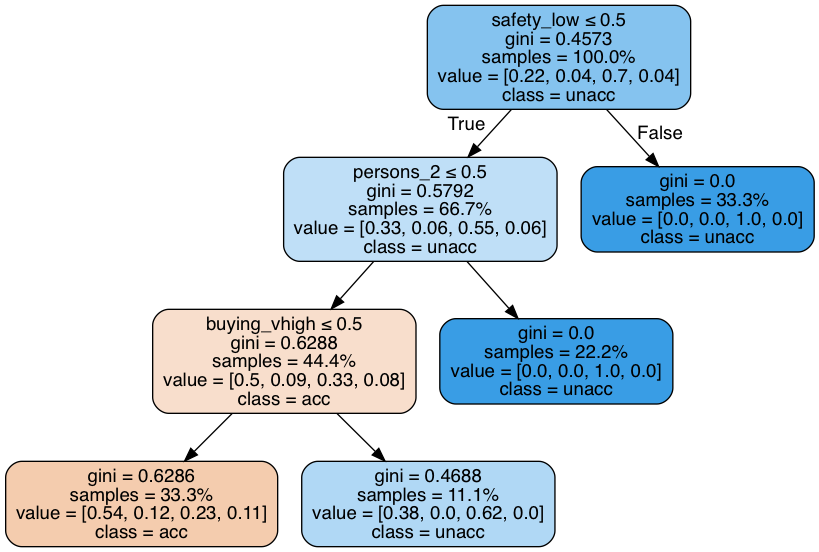

In [9]:
Image(graph[0].create_png())

The first choice involves `person_2`. If the car only takes 2 people (`person_2` == 1) then the condition (our target class) is `unacceptable`. This happens in 33% of the cases. Note that the leaf under the `False` branch is 100% pure, and therefore its Gini measure is 0.0.

On the other hand, if the car can hold more than 2 people, we will need to consider other choices. For example if the car is unsafe, then it's also unacceptable. And so on.


Recall the equation for gini:

$$
\text{Gini}(t) = 1 - \sum_{i=0}^{c-1} [p(i|t)]^2
$$

where $$ p(i|t) $$ is just the proportion of records that belong to class _i_ at a given node _t_.

This equation holds true for any number of classes, not just binary classification.  So we can use it here where we have four classes.

As a reminder, let's plot the gini index for various proportions in a binary classification:

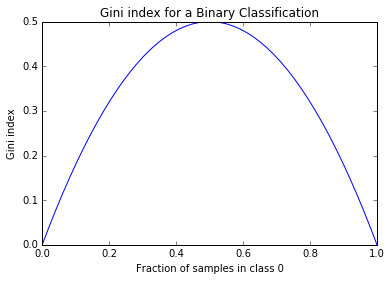

In [10]:
C0 = np.linspace(0,1)
C1 = 1.0 - C0
# Because it's binary, you can't do worse than .50
gini = 1 - (C0**2 + C1**2)
plt.plot(C0, gini)
plt.title('Gini index for a Binary Classification') 
plt.xlabel('Fraction of samples in class 0')
plt.ylabel('Gini index')

The gini index takes a value of 0 for total purity (one class represented), and takes its maximum value when all the classes are equally represented (in the case of a binary classifier, this value is 0.5, but it varies with the number of classes).

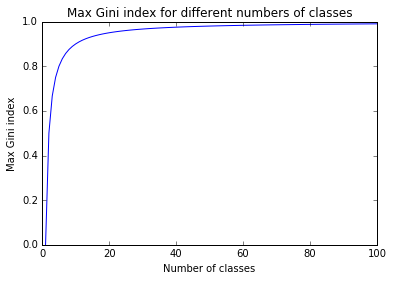

In [11]:
gini_list = []
for i in range(1,101):
    gini = 1- i*(1.0/i)**2
    gini_list.append(gini)
plt.plot(range(1,101), gini_list)
plt.title('Max Gini index for different numbers of classes') 
plt.xlabel('Number of classes')
plt.ylabel('Max Gini index')

## Back to our example:

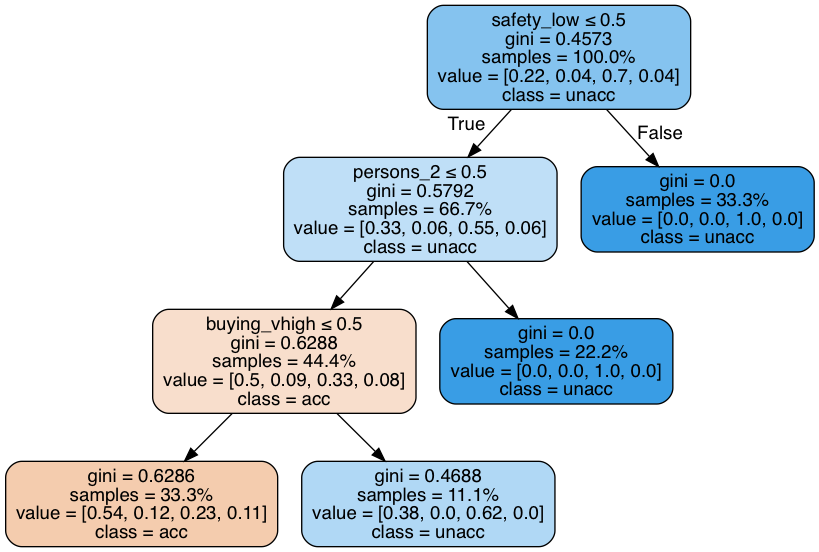

In [12]:
Image(graph[0].create_png())

Let's verify the calculation of the Gini index in the root node of the tree above:

In [13]:
root_node_values = [0.22, 0.04, 0.7, 0.04]

def gini(values):
    tot = 0.0
    for val in values:
        tot += val ** 2
    
    return 1.0 - tot

gini(root_node_values)

0.45840000000000003

Great, now we are ready to look at feature importances in our tree.

Remember: the importance of a feature is computed as the (normalized) total reduction of the impurity brought by that feature. 

Normalized by what?

By the total reduction in impurity achieved in the entire tree.

We can calculate this in sklearn

In [14]:
feature_importances = pd.DataFrame(dt.feature_importances_,
                                   index = X.columns,
                                    columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False).head()

,importance
persons_2,0.545239
safety_low,0.363493
buying_vhigh,0.091268
buying_high,0.000000
doors_5more,0.000000


Since we artificially constricted the tree to be small, only 3 features are used to make splits. Let's verify the calculation of the importance.

In [15]:
gini_gain_persons_2  = 1.0 * 0.45728376  - 0.667 * 0.57923569 - 0.333 * 0.0
gini_gain_safety_low   = 0.666 * 0.57923569 - 0.444 * 0.62880113 - 0.222 * 0.0
gini_gain_buying_vhigh = 0.444 * 0.62880113 - 0.333 * 0.6285747 - 0.111 * 0.46875

# Calc total decrease in node impurity, weighted by prob of reaching that node (i.e. % of samples there)
total_gain = gini_gain_persons_2 + gini_gain_safety_low + gini_gain_buying_vhigh

print "safety_low:", gini_gain_safety_low / total_gain
print "persons_2:", gini_gain_persons_2 / total_gain
print "buying_vhigh:", gini_gain_buying_vhigh / total_gain

safety_low: 0.545579514578
persons_2: 0.363095401091
buying_vhigh: 0.0913250843306


Note that since feature importance depends both on purity gain and number of samples at that node, features that appear higher in the tree will tend to have greater importance.

<a name="guided-practice"></a>
## Guided Practice: Feature importance in Ensemble models (25 min)

Scikit-learn [implements feature importance](http://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined) for random forest and extra trees methods.

Let's train a random forest and investigate the feature importance


### Random Forest

Recall:

- Each tree built on bootstrapped sample of data, and predictions aggregated ("bagging")
- Each split in teach tree done on random subset of features ("feature bagging")

> **Check:** How would you extend the definition of feature importance from decision trees to random forests?

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Random forest exposes the feature importance and it calculates it as the average feature importance of the trees.

In [17]:
importances = rf.feature_importances_
importances

array([ 0.05847753,  0.06830186,  0.04134968,  0.05534383,  0.04391914,
        0.04854722,  0.02927521,  0.06137861,  0.03643096,  0.01619275,
        0.00979027,  0.00929266,  0.10474907,  0.02193782,  0.01760117,
        0.05452722,  0.02516144,  0.07724874,  0.08507457,  0.09293226,
        0.04246798])

Let's compare the 2 models (re-init Decision Tree with no max depth constraint)

In [18]:
dt = DecisionTreeClassifier()
dt.fit(X, y)
importances = pd.DataFrame(zip(dt.feature_importances_,rf.feature_importances_,),
                           index=X.columns, columns=['dt_importance','rf_importance']).sort_values('rf_importance',ascending=False)               
importances.head()

,dt_importance,rf_importance
persons_2,0.155542,0.104749
safety_low,0.233312,0.092932
safety_high,0.042817,0.085075
lug_boot_small,0.094315,0.077249
buying_low,0.011548,0.068302


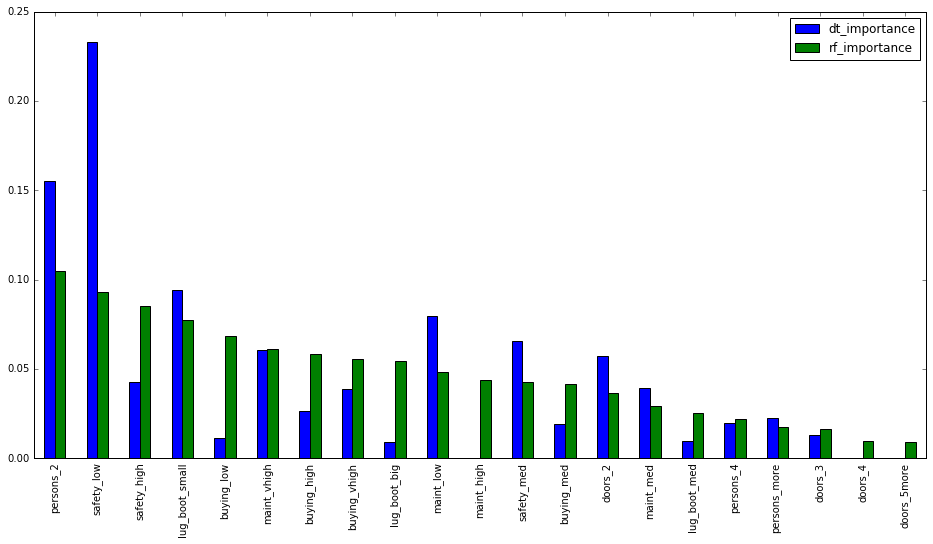

In [19]:
fig, ax = plt.subplots(figsize=(16,8))
importances.plot(kind='bar', ax=ax)

**Check:** Discuss in your tables the plot above. What are the common things across the models? What are the differences?

## What happens if our features are highly correlated?

Word of warning wrt interprations: 

If we have two highly correlated features, our model could split on either to achieve the same effect.  But once it has split on one of the features, the power of the other is greatly reduced because the purity gain has been realized.  So the second feature may show up with no importance.

This may cause problems with interpretation if one of the features has no causal effect, but is correlated with a feature that does have a causal effect.

This is mitigated slightly by random forests, since each forest sees a only a subset of all the features.

<a name="conclusion"></a>
## Conclusion (5 min)

In this class we learned about feature importance and how they are calculated for tree based models.
We have also deepened our understanding of the Gini measure.



### ADDITIONAL RESOURCES

- [Gini Importance](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#giniimp)
- [DT Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
- [Feature Importance in Sklearn Blog](http://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/)
- [Plot Feature Importances example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
- [Selecting good features](http://blog.datadive.net/selecting-good-features-part-iii-random-forests/)